We will be starting off with doing the EDA of our data to better understand what is going on.


In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
import pandas as pd
import optuna
from catboost import CatBoostRegressor, Pool
import smogn  


c:\Users\u507155\OneDrive - WNS\Desktop\Week1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#importing the dataset
df=pd.read_csv('Abalone_dataset(Data).csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
#checking for the missing values
print(df.isnull().sum())

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64


As we can see that there are no missing values,So there is no need to preprocess our data for missing values .


In [5]:
print(df.describe())


            Length     Diameter       Height  Whole weight  Shucked weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera weight  Shell weight        Rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.

From here in the Rings Column we can see that the Ring varies from 1 to 29 and the 1st quartile is 8 and the 3rd quartile is 11 , that means 50% of our data lies in that region


In [6]:
print(df.describe(include=['object']))

         Sex
count   4177
unique     3
top        M
freq    1528


Numerical columns: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']


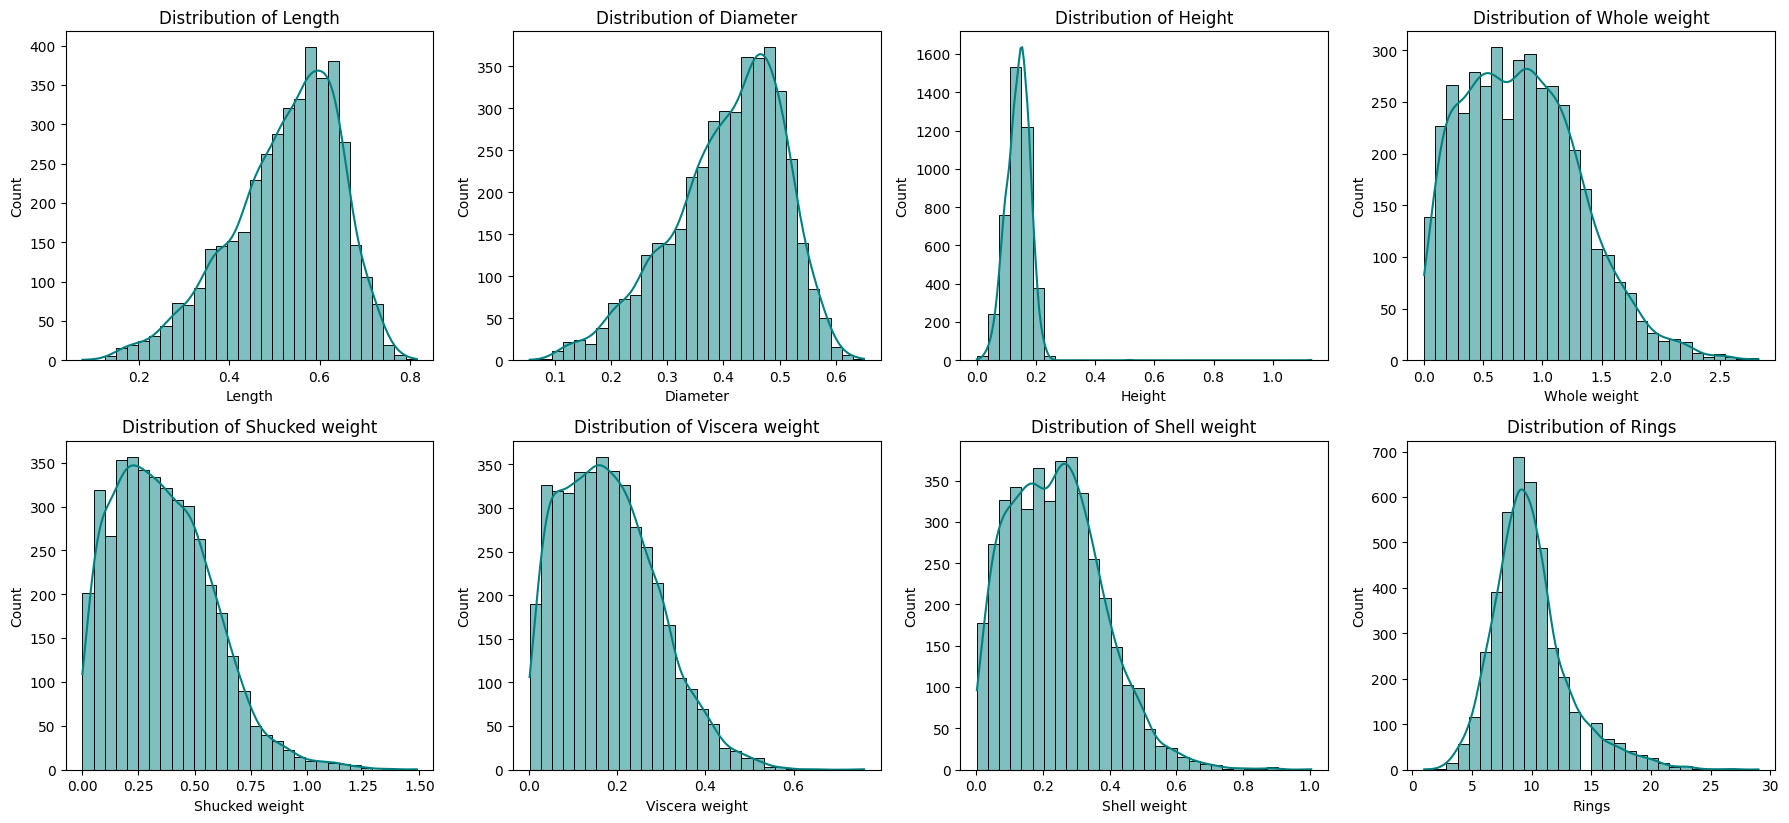

In [7]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Numerical columns: {num_cols}")

plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col], bins=30, kde=True, color='teal')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

From the above graph we can see that our Target Variable has a central peak (7-10 Rings). Hence,Predicting extreme ages(low/high) will be difficult.

Ans some features like  Height show very low variance ,meaning they might not contribute much.

C:\Users\u507155\AppData\Local\Temp\ipykernel_21700\78920101.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sex', palette='pastel')


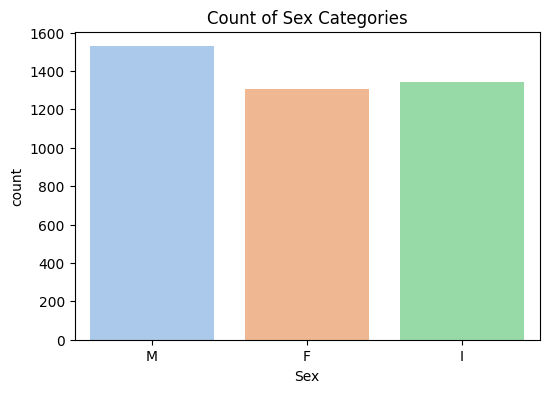

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sex', palette='pastel')
plt.title('Count of Sex Categories')
plt.show()

print(df['Sex'].value_counts())

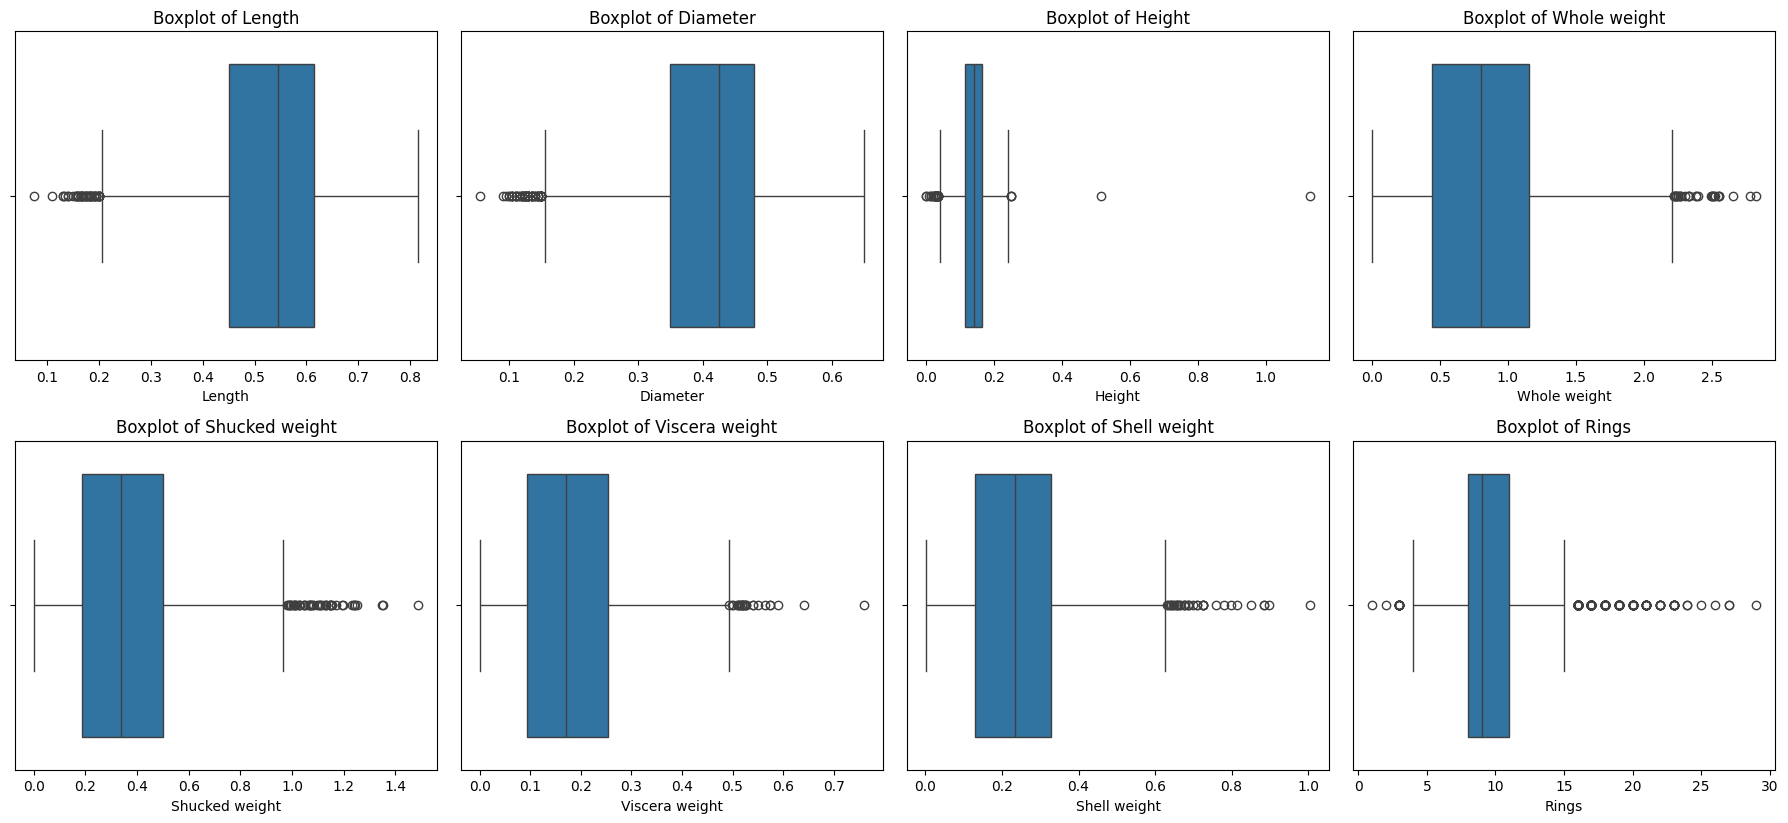

In [9]:
#for seeing the outliers 
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

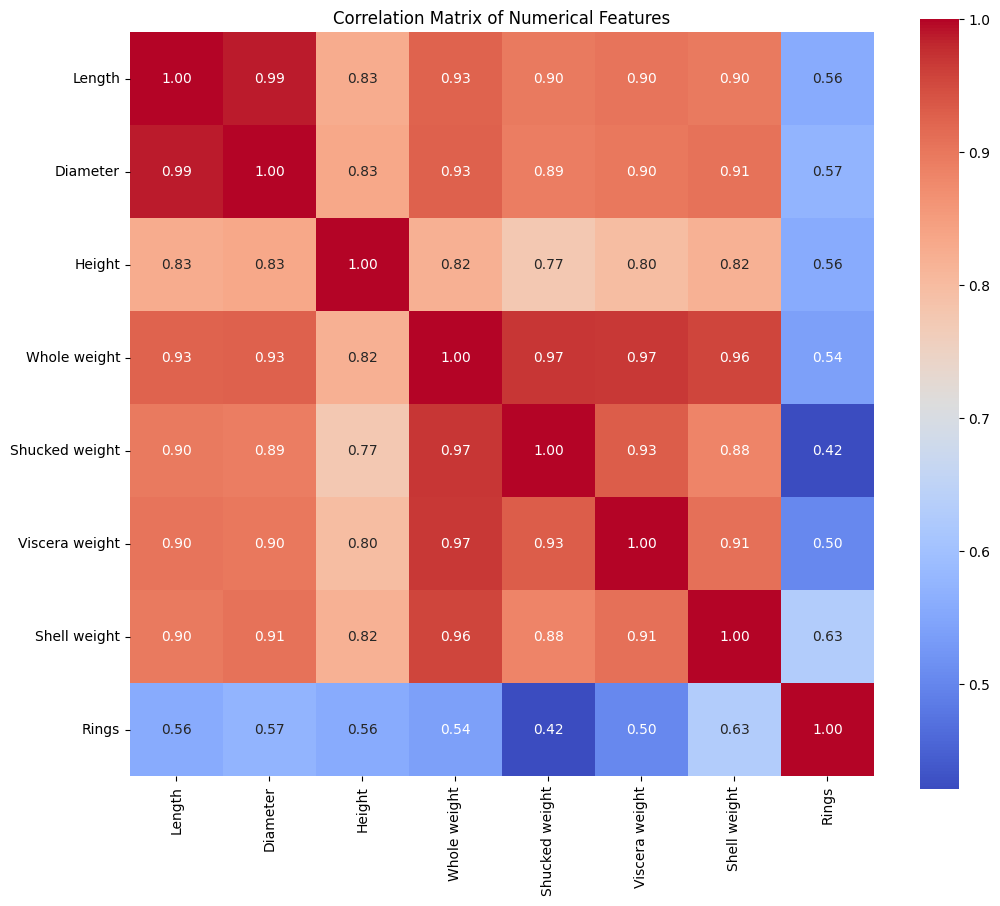

In [10]:
#  Correlation Matrix 
plt.figure(figsize=(12,10))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

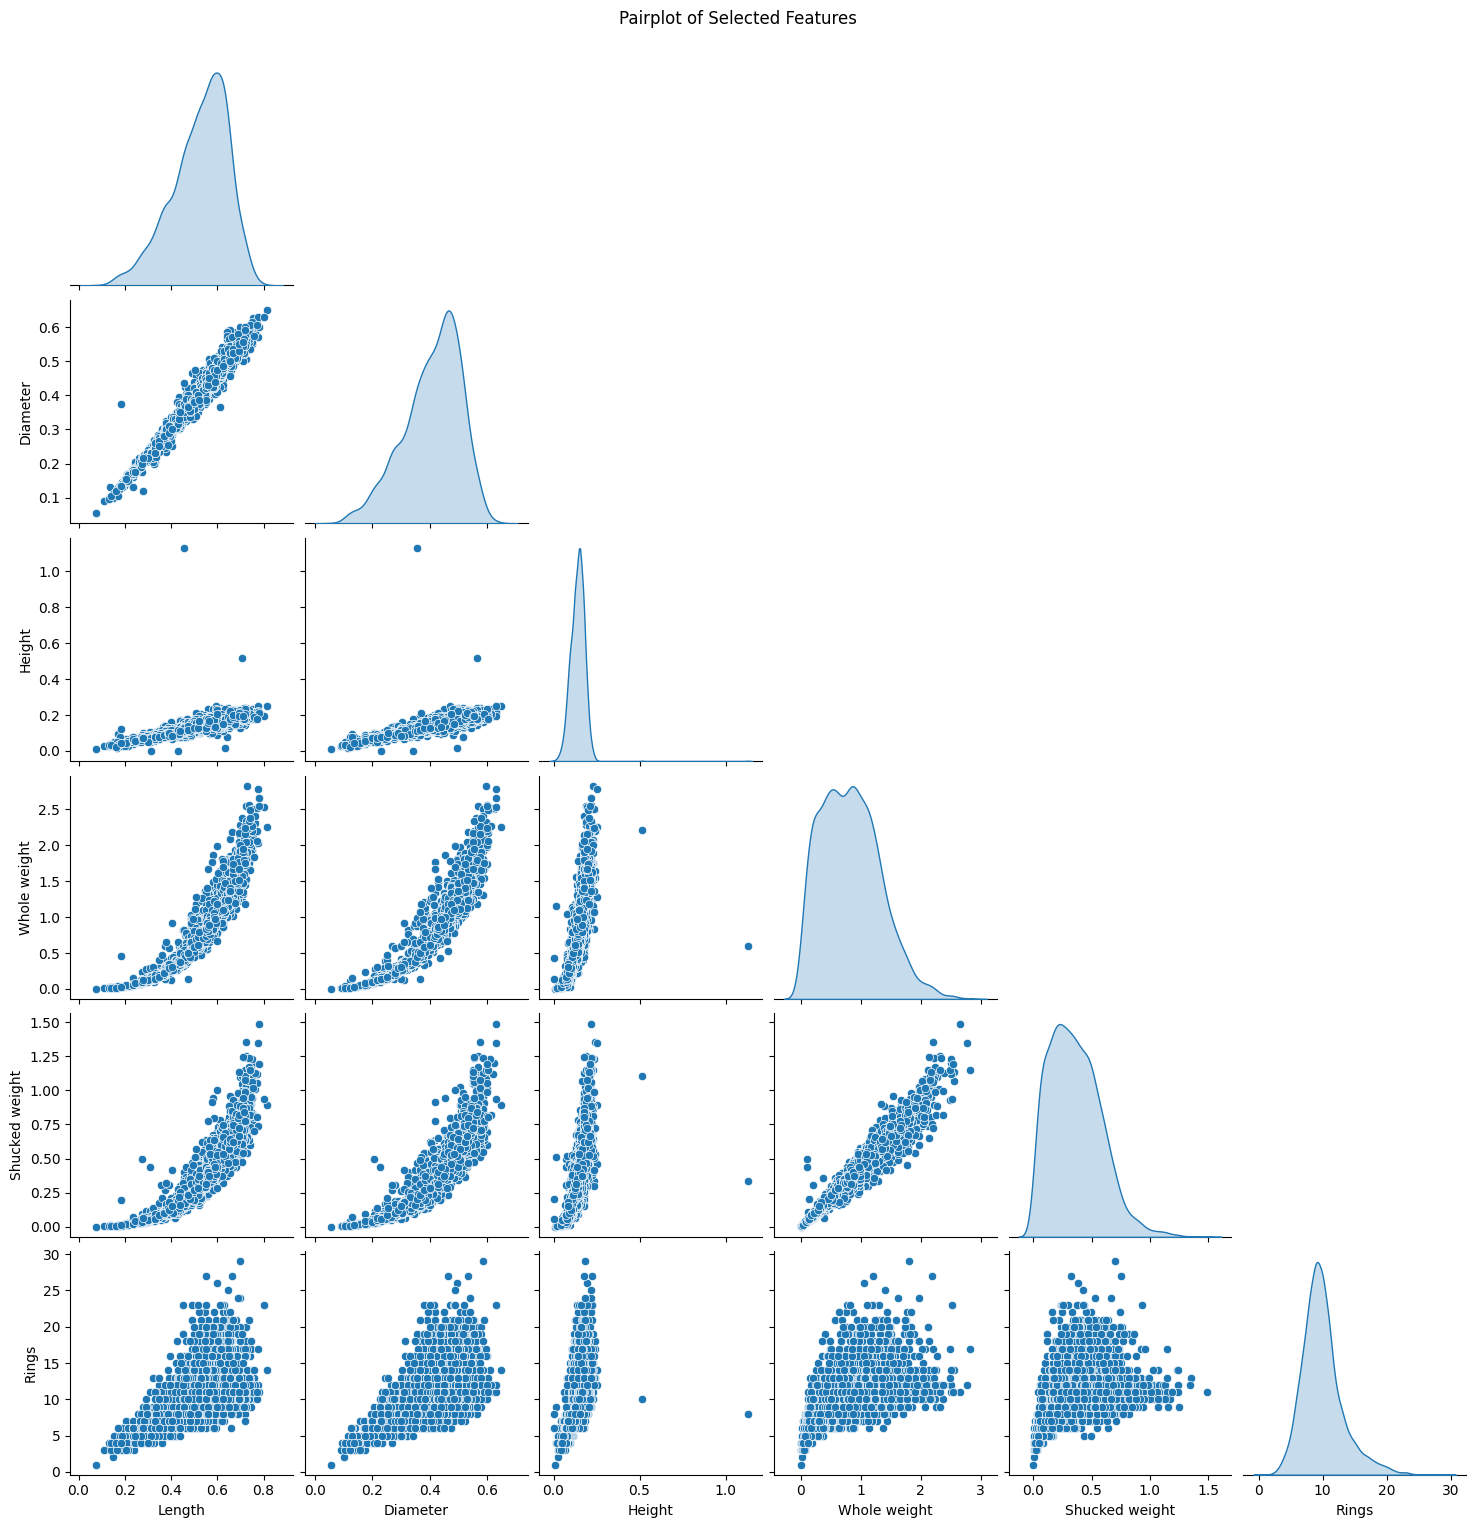

In [11]:
# === 8. Pairplot of Selected Important Features (including target Age) ===
selected_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Rings']
sns.pairplot(df[selected_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

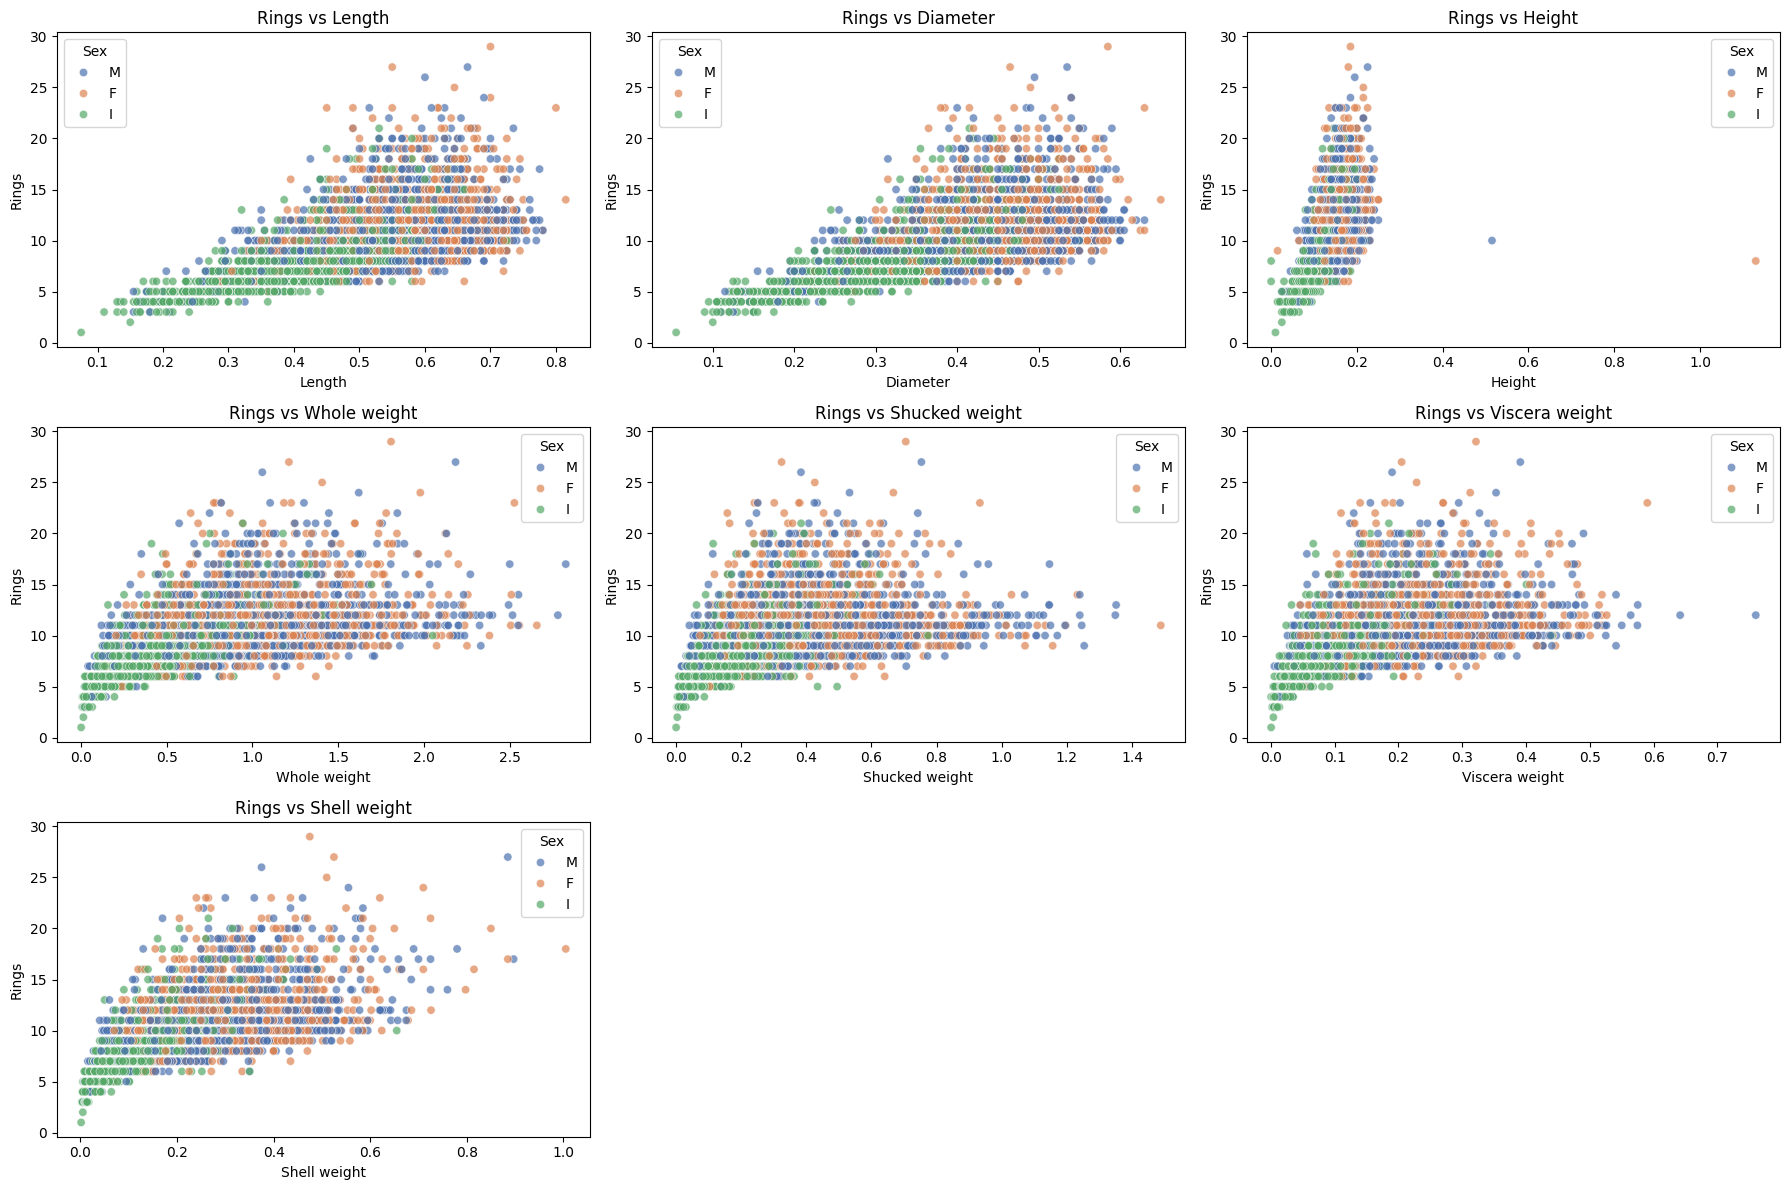

In [12]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols):
    if col == 'Rings':  # skip target vs itself
        continue
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=df, x=col, y='Rings', hue='Sex', palette='deep', alpha=0.7)
    plt.title(f'Rings vs {col}')
plt.tight_layout()
plt.show()

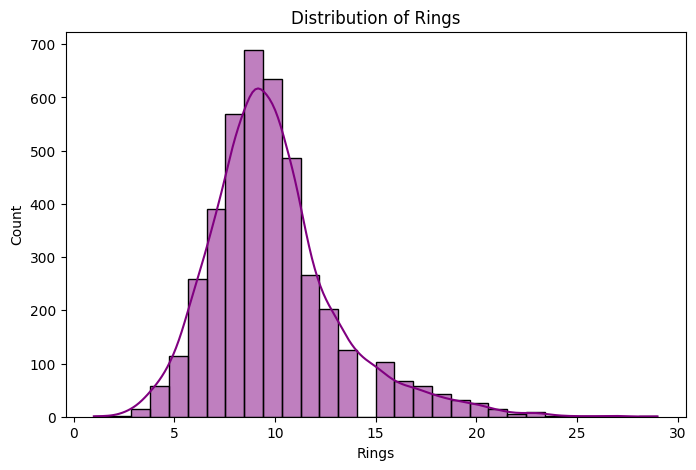

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['Rings'], bins=30, kde=True, color='purple')
plt.title('Distribution of Rings')
plt.xlabel('Rings')
plt.show()


In [14]:
Q1 = df['Rings'].quantile(0.25)
Q3 = df['Rings'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Rings Outlier Bounds: Lower = {lower_bound}, Upper = {upper_bound}")
outliers = df[(df['Rings'] < lower_bound) | (df['Rings'] > upper_bound)]
print(f"Number of Rings outliers: {outliers.shape[0]}")

Rings Outlier Bounds: Lower = 3.5, Upper = 15.5
Number of Rings outliers: 278


In [15]:
#Summary of rings grouped by sex

print(df.groupby('Sex')['Rings'].describe())

      count       mean       std  min  25%   50%   75%   max
Sex                                                         
F    1307.0  11.129304  3.104256  5.0  9.0  10.0  12.0  29.0
I    1342.0   7.890462  2.511554  1.0  6.0   8.0   9.0  21.0
M    1528.0  10.705497  3.026349  3.0  9.0  10.0  12.0  27.0


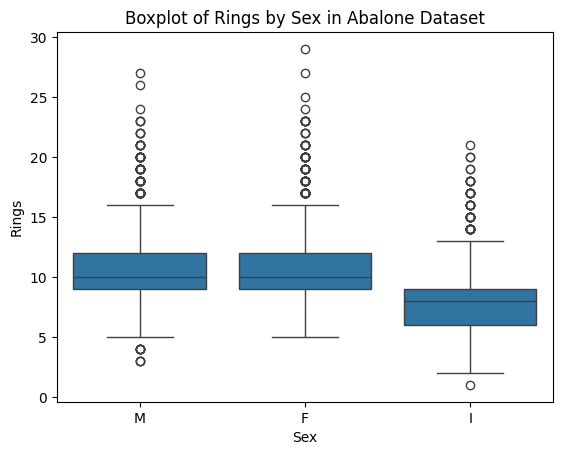

In [16]:
sns.boxplot(x='Sex', y='Rings', data=df)
plt.title('Boxplot of Rings by Sex in Abalone Dataset')
plt.show()

C:\Users\u507155\AppData\Local\Temp\ipykernel_21700\197141717.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Sex', y='Rings', data=df, palette='Set2')


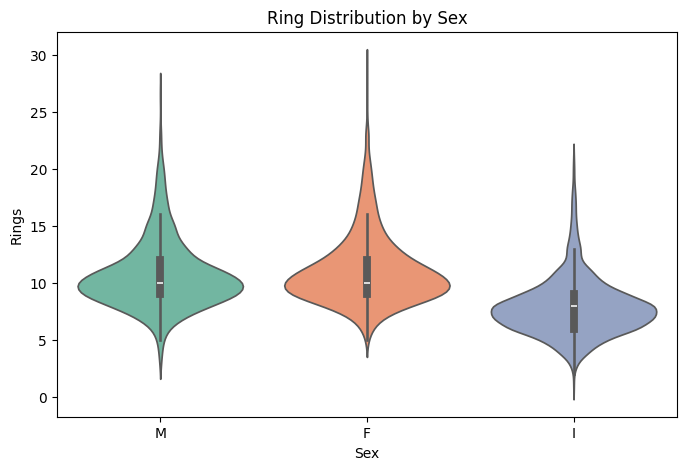

In [17]:
plt.figure(figsize=(8,5))
sns.violinplot(x='Sex', y='Rings', data=df, palette='Set2')
plt.title('Ring Distribution by Sex')
plt.show()


In [18]:
#show thw skewness of our data
skewness = df[num_cols].skew()
print(skewness)

Length           -0.639873
Diameter         -0.609198
Height            3.128817
Whole weight      0.530959
Shucked weight    0.719098
Viscera weight    0.591852
Shell weight      0.620927
Rings             1.114102
dtype: float64


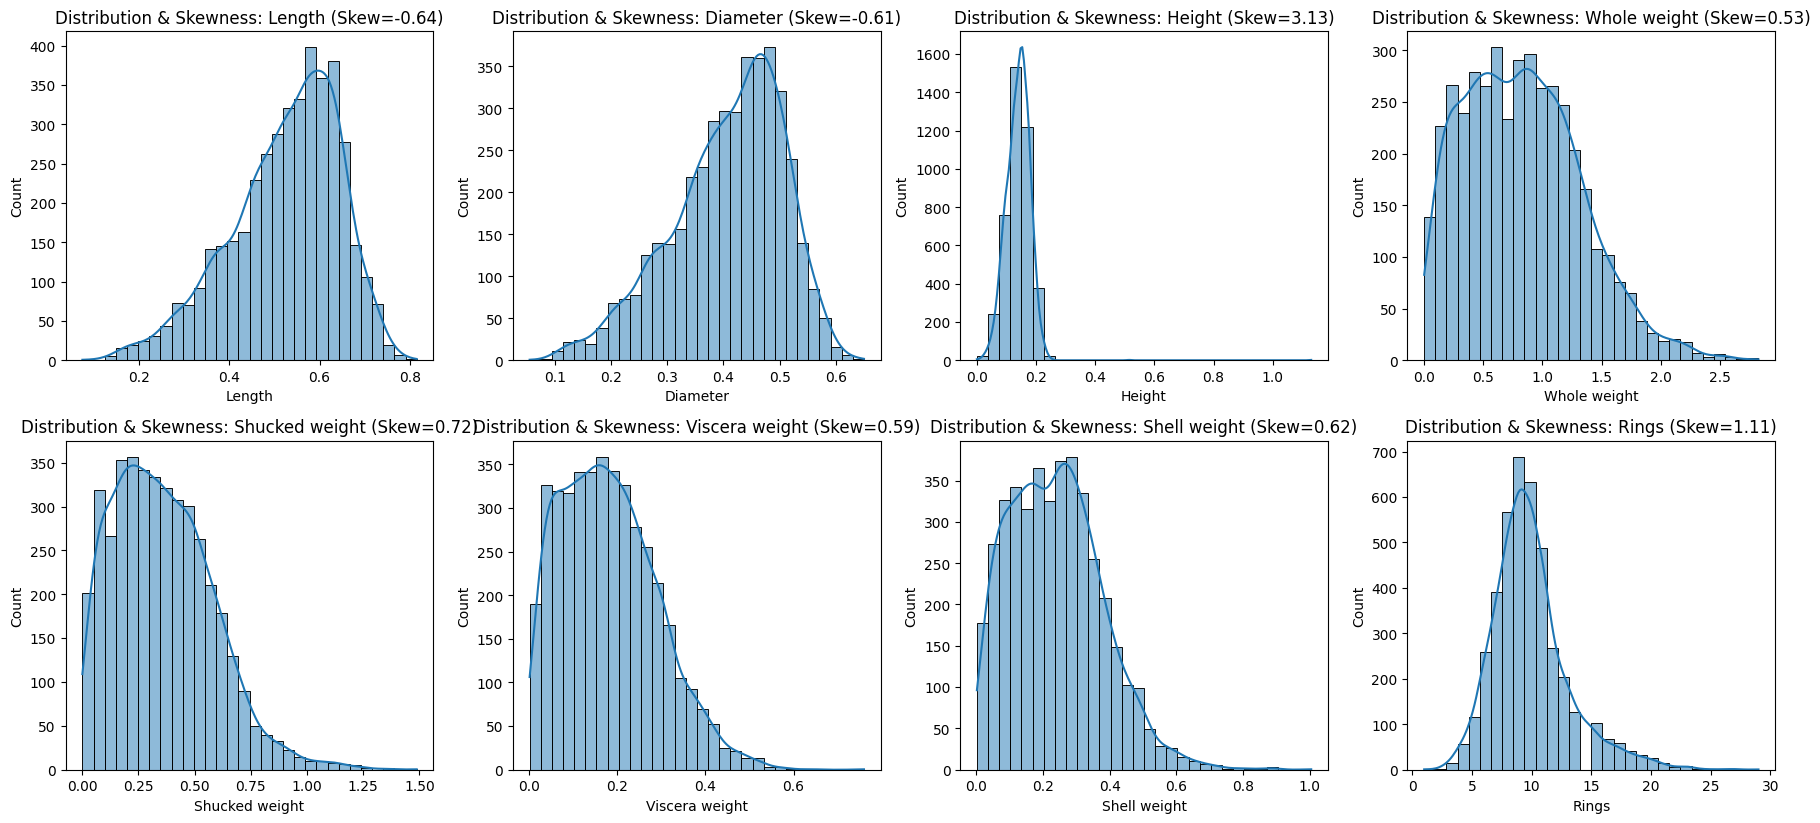

In [19]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution & Skewness: {col} (Skew={skewness[col]:.2f})')
plt.tight_layout()
plt.show()

In [20]:


# Encode 'Sex' column
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])

data=df.copy()
X = data.drop(columns=[ 'Rings'])  # Features
y = data['Rings']                          # Target

So, now i have implemented Random Forest with Hyperparameter tuning and then analyze the feature importance and make some necessary changes to feature engineering further improve the accuracy.


In [22]:

# === Step 1: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
rf=RandomForestRegressor(random_state=42)

# === Step 2: Initialize Random Forest Regressor ===
rf_params ={
    "n_estimators":[100,200,500],      # Number of trees
    "max_depth":[3,10,15,None],        # Let trees grow fully
    "min_samples_leaf":[1,2,4],
    "max_features":["sqrt","log2",None]}
    


rf_grid=RandomizedSearchCV(rf,rf_params,n_iter=20,cv=3,n_jobs=-1,scoring="r2",random_state=42)
rf_grid.fit(X_train,y_train)
y_pred=rf_grid.predict(X_test)
print("R2:",r2_score(y_test,y_pred))
print("MAE:",mean_absolute_error(y_test,y_pred))
print("Best para",rf_grid.best_params_)


R2: 0.550266164086739
MAE: 1.5564797325211206
Best para {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}


In [23]:
best_rf=rf_grid.best_estimator_
importances=best_rf.feature_importances_
features=X.columns

feat_imp=pd.DataFrame({
    "Feature":features,
    "Importance":importances
}).sort_values(by="Importance",ascending=False)
print(feat_imp)

          Feature  Importance
7    Shell weight    0.300755
4    Whole weight    0.144360
5  Shucked weight    0.135301
3          Height    0.131950
2        Diameter    0.104253
6  Viscera weight    0.095321
1          Length    0.066260
0             Sex    0.021799


So, what we see from here is that the Feature importance of Shell Weight is maximum which is expected as we saw in the correlation matrix that Shell weight has highest correlation with number of rings .

Now , we are going to implemet few other model before feature engineering just to check thier accuracies.

In [24]:
# === Step 1: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# === Step 2: Initialize XGBRegressor ===
xgb = XGBRegressor(random_state=42, n_jobs=-1)

# === Step 3: Define hyperparameter search space ===
param_dist = {
    'n_estimators': randint(100, 500),        # number of trees
    'max_depth': randint(3, 15),               # tree depth
    'learning_rate': uniform(0.01, 0.3),       # step size shrinkage
    'subsample': uniform(0.6, 0.4),            # fraction of samples for each tree
    'colsample_bytree': uniform(0.6, 0.4),     # fraction of features used per tree
    'gamma': uniform(0, 5),                     # min loss reduction to make a split
    'reg_alpha': uniform(0, 1),                 # L1 regularization
    'reg_lambda': uniform(0.5, 2),              # L2 regularization
}

# === Step 4: Setup RandomizedSearchCV ===
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,                # number of parameter settings sampled
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === Step 5: Fit model with hyperparameter search ===
xgb_search.fit(X_train, y_train)

# === Step 6: Predict and evaluate ===
y_pred = xgb_search.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("Best parameters:", xgb_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
R2: 0.5471489429473877
MAE: 1.538312554359436
Best parameters: {'colsample_bytree': np.float64(0.8430179407605753), 'gamma': np.float64(0.8526206184364576), 'learning_rate': np.float64(0.029515477895583855), 'max_depth': 6, 'n_estimators': 188, 'reg_alpha': np.float64(0.9656320330745594), 'reg_lambda': np.float64(2.1167946962329225), 'subsample': np.float64(0.7218455076693483)}


In [25]:

# === Step 1: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# === Step 2: Initialize CatBoost Regressor ===
catboost = CatBoostRegressor(
    random_seed=42,
    silent=True,           # suppress output during training
)

# === Step 3: Define hyperparameter search space ===
param_dist = {
    'iterations': randint(100, 500),
    'depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(32, 255),
    'random_strength': uniform(0, 1),
}

# === Step 4: Setup RandomizedSearchCV ===
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === Step 5: Fit model with hyperparameter search ===
random_search.fit(X_train, y_train)

# === Step 6: Predict and evaluate ===
y_pred = random_search.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("Best parameters:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
R2: 0.5456810261369829
MAE: 1.553407115675529
Best parameters: {'bagging_temperature': np.float64(0.49724850589238545), 'border_count': 144, 'depth': 7, 'iterations': 212, 'l2_leaf_reg': np.float64(10.97740485048942), 'learning_rate': np.float64(0.09003430428258549), 'random_strength': np.float64(0.9766149558326529)}


Now , we are going to do feature engineering 



•	These ratios help capture relative proportions of weights, which are more biologically meaningful than raw values alone.




•	Added polynomial interaction features to capture non-linear relationships between variables.


In [26]:
df['Shucked_Whole_Ratio'] = df['Shucked weight'] / (df['Whole weight'] + 1e-6)
df['Viscera_Whole_Ratio'] = df['Viscera weight'] / (df['Whole weight'] + 1e-6)
df['Shell_Whole_Ratio'] = df['Shell weight'] / (df['Whole weight'] + 1e-6)
df['Shell_Shucked_Ratio'] = df['Shell weight'] / (df['Shucked weight'] + 1e-6)
df['Height_Diameter_Ratio'] = df['Height'] / (df['Diameter'] + 1e-6)
df['Shell_Height_Product'] = df['Shell weight'] * df['Height']
df['Volume']=df['Length']*df['Height']*df['Diameter']


# Handle any infinite or NaN values from division if any
df.replace([float('inf'), -float('inf')], 0, inplace=True)
df.fillna(0, inplace=True)

# Select features and target
X = df.drop('Rings', axis=1)
y = df['Rings']

# Add polynomial features (interaction terms + powers)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Get new feature names
feature_names = poly.get_feature_names_out(X.columns)

# Convert back to DataFrame for convenience
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

print(f"Original features count: {X.shape[1]}")
print(f"New features count (after poly): {X_poly_df.shape[1]}")

Original features count: 15
New features count (after poly): 120


In [27]:


# Now we can use X_poly_df and y for modeling
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df, y, test_size=0.2, random_state=42)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score


# Initialize XGBoost Regressor with default params 
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"XGBoost Regression on Engineered Features:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")


XGBoost Regression on Engineered Features:
R² Score: 0.5782
Mean Absolute Error: 1.5213


In [32]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


X = df.drop('Rings', axis=1)
y = df['Rings']

# CatBoost needs categorical features as categorical type or indices
cat_features = [X.columns.get_loc('Sex')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='MAE',
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred = model.predict(X_test)

print("CatBoost Regression Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2 : {r2_score(y_test, y_pred):.4f}")


0:	learn: 2.2958086	test: 2.3226664	best: 2.3226664 (0)	total: 40.8ms	remaining: 40.7s
100:	learn: 1.3553899	test: 1.4462727	best: 1.4462554 (99)	total: 3.43s	remaining: 30.6s
200:	learn: 1.2852049	test: 1.4429663	best: 1.4398237 (178)	total: 6.74s	remaining: 26.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.439823692
bestIteration = 178

Shrink model to first 179 iterations.
CatBoost Regression Results:
MAE: 1.4398
R2 : 0.5808


As we know the class imbalance is very huge , though the imbalance is very high , we can still give SMOGN a try to see if we can reduce that , and through that we can improve our accuracy or not.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sex                    4177 non-null   int64  
 1   Length                 4177 non-null   float64
 2   Diameter               4177 non-null   float64
 3   Height                 4177 non-null   float64
 4   Whole weight           4177 non-null   float64
 5   Shucked weight         4177 non-null   float64
 6   Viscera weight         4177 non-null   float64
 7   Shell weight           4177 non-null   float64
 8   Rings                  4177 non-null   int64  
 9   Shucked_Whole_Ratio    4177 non-null   float64
 10  Viscera_Whole_Ratio    4177 non-null   float64
 11  Shell_Whole_Ratio      4177 non-null   float64
 12  Shell_Shucked_Ratio    4177 non-null   float64
 13  Height_Diameter_Ratio  4177 non-null   float64
 14  Shell_Height_Product   4177 non-null   float64
 15  Volu

In [38]:


df_resampled = smogn.smoter(
    data = df,
    y = "Rings",
    k = 3,  # k-nearest neighbors
    samp_method = 'balance',  # trying to balance
    rel_thres = 0.8,
    rel_method = 'auto',
    rel_xtrm_type = 'high',  # make extreme values more important
    rel_coef = 0.5
)

# 3. Separate features and target again
X_res = df_resampled.drop(columns=['Rings'])
y_res = df_resampled['Rings']

# 4. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

# 5. Train a regression model (XGBoost here)
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 6. Predict and evaluate on test
y_pred = model.predict(X_test)
print("After Synthetic Oversampling with SMOGN:")
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")


r_index: 100%|##########| 167/167 [00:00<00:00, 1010.97it/s]


After Synthetic Oversampling with SMOGN:
R²: 0.5756
MAE: 2.9502


As we are changing the distribution of our data by oversampling rare Rings values. This helps reduce bias toward the majority but increases variance and prediction error (MAE), especially on the bulk of the normal data.
Hence, though our R2 has increased our MAE has also increased by a lot which is not a good sign.

Since Rings represent the age (in years roughly), MAE is often more interpretable and practical — it tells you the average age prediction error directly.

R² is useful to assess overall model fit but can sometimes be misleading if the model is biased towards common age ranges and ignores rarer ages.

CATBOOST+OPTUNA for hyperparameter tuning

In [34]:
# Features and target
X = df.drop('Rings', axis=1)
y = df['Rings']

# Compute inverse frequency weights
freq = y.value_counts(normalize=True)
weights = y.map(lambda x: 1 / freq[x])
weights /= weights.mean()

# Split data
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

# Categorical feature indices
cat_features = [X.columns.get_loc('Sex')]

# Optuna objective function
def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'iterations': 1000,
        'loss_function': 'MAE',
        'early_stopping_rounds': 50,
        'random_seed': 42,
        'verbose': 0
    }

    train_pool = Pool(X_train, y_train, cat_features=cat_features, weight=w_train)
    valid_pool = Pool(X_test, y_test, cat_features=cat_features, weight=w_test)

    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool)

    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

# Run Optuna tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Train best model
best_params = study.best_params
best_model = CatBoostRegressor(
    **best_params,
    iterations=1000,
    loss_function='MAE',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)

train_pool = Pool(X_train, y_train, cat_features=cat_features, weight=w_train)
best_model.fit(train_pool, eval_set=(X_test, y_test))

# Predict and evaluate
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")


[I 2025-09-29 12:31:37,031] A new study created in memory with name: no-name-b7da55a9-aa4d-42c8-8794-d6980092e2a0


[I 2025-09-29 12:31:40,442] Trial 0 finished with value: 1.457341133688786 and parameters: {'depth': 5, 'learning_rate': 0.1430795960038775, 'l2_leaf_reg': 6.976933769238091, 'bagging_temperature': 0.2264828357479569, 'random_strength': 0.591989752338217}. Best is trial 0 with value: 1.457341133688786.
[I 2025-09-29 12:32:07,789] Trial 1 finished with value: 1.4423659034026133 and parameters: {'depth': 8, 'learning_rate': 0.020222501841236633, 'l2_leaf_reg': 0.4106836403655985, 'bagging_temperature': 0.9304333369329805, 'random_strength': 0.13518496712418937}. Best is trial 1 with value: 1.4423659034026133.
[I 2025-09-29 12:32:10,833] Trial 2 finished with value: 1.4860317009947481 and parameters: {'depth': 4, 'learning_rate': 0.19377518424279094, 'l2_leaf_reg': 0.2559213632931274, 'bagging_temperature': 0.09154099381036929, 'random_strength': 0.18017051026334263}. Best is trial 1 with value: 1.4423659034026133.
[I 2025-09-29 12:32:21,355] Trial 3 finished with value: 1.446651170178408

0:	learn: 7.2637788	test: 5.4846557	best: 5.4846557 (0)	total: 47.5ms	remaining: 47.5s
100:	learn: 5.6855248	test: 2.1647785	best: 2.1647785 (100)	total: 4.22s	remaining: 37.6s
200:	learn: 5.0141853	test: 1.5596406	best: 1.5596406 (200)	total: 8.33s	remaining: 33.1s
300:	learn: 4.6020867	test: 1.4583823	best: 1.4583823 (300)	total: 11.6s	remaining: 27s
400:	learn: 4.3537216	test: 1.4420181	best: 1.4418214 (395)	total: 15.7s	remaining: 23.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.439623935
bestIteration = 448

Shrink model to first 449 iterations.
Best Hyperparameters: {'depth': 6, 'learning_rate': 0.013330013813896728, 'l2_leaf_reg': 1.4457026937750768, 'bagging_temperature': 0.22017903229952335, 'random_strength': 0.6486962631076414}
Test MAE: 1.4396
Test R² : 0.5816


In [35]:
!pip install joblib

In [39]:
import joblib

joblib.dump(best_model, 'catboost_abalone_model.pkl')
print("Model saved as catboost_abalone_model.pkl")
loaded_model = joblib.load('catboost_abalone_model.pkl')


Model saved as catboost_abalone_model.pkl


In [ ]:
import streamlit as st
import joblib
import numpy as np

# Load the trained model
model = joblib.load('catboost_abalone_model.pkl')

# Streamlit Page Configuration
st.set_page_config(page_title="Abalone Age Predictor", layout="centered")
st.title("🐚 Abalone Age Prediction")
st.markdown("Estimate the age of an abalone using physical measurements (non-invasive method).")

# -------------------
# 📥 Input Features
# -------------------
sex = st.selectbox("Sex", ["M", "F", "I"])
length = st.number_input("Length (mm)", min_value=0.0, format="%.3f")
diameter = st.number_input("Diameter (mm)", min_value=0.0, format="%.3f")
height = st.number_input("Height (mm)", min_value=0.0, format="%.3f")
whole_weight = st.number_input("Whole Weight (g)", min_value=0.0, format="%.3f")
shucked_weight = st.number_input("Shucked Weight (g)", min_value=0.0, format="%.3f")
viscera_weight = st.number_input("Viscera Weight (g)", min_value=0.0, format="%.3f")
shell_weight = st.number_input("Shell Weight (g)", min_value=0.0, format="%.3f")

# -------------------
# 🧠 Preprocessing
# -------------------
# Encode the Sex feature
sex_encoded = {'M': 0, 'F': 1, 'I': 2}
sex_value = sex_encoded[sex]

# Ratio features
shucked_whole_ratio = shucked_weight / whole_weight if whole_weight else 0
viscera_whole_ratio = viscera_weight / whole_weight if whole_weight else 0
shell_whole_ratio = shell_weight / whole_weight if whole_weight else 0

# Feature vector
input_features = np.array([[sex_value, length, diameter, height,
                            whole_weight, shucked_weight, viscera_weight,
                            shell_weight,
                            shucked_whole_ratio, viscera_whole_ratio, shell_whole_ratio]])

# -------------------
# 🎯 Predict
# -------------------
if st.button("🔍 Predict Abalone Age"):
    predicted_rings = model.predict(input_features)[0]
    predicted_age = predicted_rings + 1.5

    st.success(f"📏 Predicted Growth Rings: {predicted_rings:.2f}")
    st.markdown(f"### 🕒 Estimated Age: `{predicted_age:.2f} years`")

    st.caption("Note: Age is calculated as Rings + 1.5 (biological offset)")
